In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px

# Load data

In [2]:
def create_final_dataframe(main_data):
    #load all aditional dataframes
    oil_data = pd.read_csv("./Data/oil.csv", parse_dates= ["date"])
    holiday_data = pd.read_csv("./Data/holidays_events.csv", parse_dates= ["date"])
    stores_data = pd.read_csv("./Data/stores.csv")
    trans_data = pd.read_csv("./Data/transactions.csv", parse_dates= ['date'])

    # preprocess dataframes: updating datatypes and filling missing values

    main_datatype = {"store_nbr": "category", "family" :"category"}
    main_data = main_data.astype(main_datatype)

    oil_data.fillna(method = "backfill", inplace = True)

    holiday_datatypes = {"type": "category","locale":"category", "locale_name": "category", "description": "string"}
    holiday_data = holiday_data.astype(holiday_datatypes)

    stores_data = stores_data.astype("category")

    # split holiday dataframe based on holiday types
    holiday_local  = holiday_data[holiday_data["locale"]== "Local"].copy()
    holiday_local.rename(columns={'locale_name': 'city'}, inplace=True)
    holiday_local= holiday_local.drop_duplicates(subset=['date', 'city'])
    holiday_regional  = holiday_data[holiday_data["locale"]== "Regional"].copy()
    holiday_regional.rename(columns={'locale_name': 'state'}, inplace=True)
    holiday_regional= holiday_regional.drop_duplicates(subset=['date', 'state'])
    holiday_national = holiday_data[holiday_data["locale"]== "National"].copy()
    holiday_national= holiday_national.drop_duplicates(subset=['date'])

    # merging all frames to create the final dataframe: 
    df = main_data.merge(oil_data, on = "date", how = "left").fillna(method = 'ffill')
    df = df.merge(stores_data, on = "store_nbr", how = "left", )
    df = df.merge(trans_data, on = ["date", "store_nbr"], how = "left")
    df = df.merge(holiday_local, on = ["date", "city"], how = "left", suffixes= ("_store", "_holiday")) 
    df = df.merge(holiday_regional, on = ["date", "state"], how = "left",)
    df = df.merge(holiday_national, on ="date", how = "left")
    
    # Filing missing values of type holiday variable in the df dataframe
    type_holiday = df['type_holiday'].combine_first(df['type_x']).combine_first(df['type_y'])
    locale = df['locale_x'].combine_first(df['locale_y']).combine_first(df['locale'])
    transferred =  df['transferred_x'].combine_first(df['transferred_y']).combine_first(df['transferred'])
    
    # create the final version of df dataframe by adding the correct columns of holiday dataframe
    df = df.iloc[:, :11]
    df['type_holiday']= type_holiday
    df['locale']= locale
    df['transferred'] = transferred

    # trim the final dataframe by improving its columns' datatypes and imputing the missing values
    df['type_holiday'] = df['type_holiday'].cat.add_categories("IsNotHoliday")  
    df['locale'] = df['locale'].cat.add_categories("IsNotHoliday") 

    fill_values = {"type_holiday" :"IsNotHoliday", "locale":"IsNotHoliday"}
    df.fillna(fill_values, inplace = True)

    df.fillna({"transferred": False, "transactions": 0}, inplace = True)

    df = df.astype({"city":"category", "state": "category"})

    return df


In [3]:
train_data = pd.read_csv("./Data/train.csv", parse_dates = ['date'] ,  index_col='id')

df = create_final_dataframe(train_data)

df

C:\Users\solmaz\AppData\Local\Temp\ipykernel_16992\138621633.py:54: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.fillna(fill_values, inplace = True)


,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_store,cluster,transactions,type_holiday,locale,transferred
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False


In [4]:
test_data = pd.read_csv("./Data/test.csv",  index_col='id', parse_dates = ['date'] )
test_frame = create_final_dataframe(test_data.iloc[:1, :])

test_frame

C:\Users\solmaz\AppData\Local\Temp\ipykernel_16992\138621633.py:54: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.fillna(fill_values, inplace = True)


,date,store_nbr,family,onpromotion,dcoilwtico,city,state,type_store,cluster,transactions,type_holiday,locale,transferred
0,2017-08-16,1,AUTOMOTIVE,0,46.8,Quito,Pichincha,D,13,0.0,IsNotHoliday,IsNotHoliday,False


In [5]:
def extract_time_vars(dataframe):
    dataframe['year'] = dataframe["date"].apply(lambda x: x.year)
    dataframe['month'] = dataframe["date"].apply(lambda x: x.month)
    dataframe['day'] = dataframe["date"].apply(lambda x : x.day)
    dataframe['dayweek'] = dataframe["date"].apply(lambda x : x.day_name()).astype("category")
    dataframe["quarter"] = dataframe["date"].apply(lambda x: x.quarter)
    dataframe["weekyear"]= dataframe["date"].apply(lambda x: x.weekofyear).astype(bool)
    dataframe["isweekend"] = dataframe["date"].dt.dayofweek // 5 

    return dataframe

In [6]:
df = extract_time_vars(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 21 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   store_nbr     int64         
 2   family        category      
 3   sales         float64       
 4   onpromotion   int64         
 5   dcoilwtico    float64       
 6   city          category      
 7   state         category      
 8   type_store    category      
 9   cluster       category      
 10  transactions  float64       
 11  type_holiday  category      
 12  locale        category      
 13  transferred   bool          
 14  year          int64         
 15  month         int64         
 16  day           int64         
 17  dayweek       category      
 18  quarter       int64         
 19  weekyear      bool          
 20  isweekend     int64         
dtypes: bool(2), category(8), datetime64[ns](1), float64(3), int64(7)
memory usage: 303.4 MB


In [11]:
# Seasons in Ecuador :Dry season : october- May, wet season : Jun-Septamber
def season(x):
    if 6<= x <=9:
        return 'W'
    else:
        return "D"
df['season'] = df['month'].apply(season)

df

,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_store,cluster,...,locale,transferred,year,month,day,dayweek,quarter,weekyear,isweekend,season
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13,...,National,False,2013,1,1,Tuesday,1,True,0,D
1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13,...,National,False,2013,1,1,Tuesday,1,True,0,D
2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13,...,National,False,2013,1,1,Tuesday,1,True,0,D
3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13,...,National,False,2013,1,1,Tuesday,1,True,0,D
4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13,...,National,False,2013,1,1,Tuesday,1,True,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,...,IsNotHoliday,False,2017,8,15,Tuesday,3,True,0,W
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,...,IsNotHoliday,False,2017,8,15,Tuesday,3,True,0,W
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,...,IsNotHoliday,False,2017,8,15,Tuesday,3,True,0,W
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,...,IsNotHoliday,False,2017,8,15,Tuesday,3,True,0,W


## Extract some new time features

In [16]:
df1 = df.copy()
df1["yearmonth"] = pd.to_datetime(df1["year"].astype(str) + "-" + df1["month"].astype(str), format="%Y-%m")
df1["yearquarter"] = df1["year"].astype(str) + "-Q" + df1["month"].apply(lambda x: (int(x) - 1) // 3 + 1).astype(str)
df1["yearweek"] = df1["year"].astype(str) + "-W" + df1["weekyear"].apply(lambda x: str(x).zfill(2))



In [17]:
df1.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico',
       'city', 'state', 'type_store', 'cluster', 'transactions',
       'type_holiday', 'locale', 'transferred', 'year', 'month', 'day',
       'dayweek', 'quarter', 'weekyear', 'isweekend', 'season', 'yearmonth',
       'yearquarter', 'yearweek'],
      dtype='object')

In [18]:
df1

,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_store,cluster,...,month,day,dayweek,quarter,weekyear,isweekend,season,yearmonth,yearquarter,yearweek
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13,...,1,1,Tuesday,1,True,0,D,2013-01-01,2013-Q1,2013-WTrue
1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13,...,1,1,Tuesday,1,True,0,D,2013-01-01,2013-Q1,2013-WTrue
2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13,...,1,1,Tuesday,1,True,0,D,2013-01-01,2013-Q1,2013-WTrue
3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13,...,1,1,Tuesday,1,True,0,D,2013-01-01,2013-Q1,2013-WTrue
4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13,...,1,1,Tuesday,1,True,0,D,2013-01-01,2013-Q1,2013-WTrue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,...,8,15,Tuesday,3,True,0,W,2017-08-01,2017-Q3,2017-WTrue
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,...,8,15,Tuesday,3,True,0,W,2017-08-01,2017-Q3,2017-WTrue
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,...,8,15,Tuesday,3,True,0,W,2017-08-01,2017-Q3,2017-WTrue
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,...,8,15,Tuesday,3,True,0,W,2017-08-01,2017-Q3,2017-WTrue


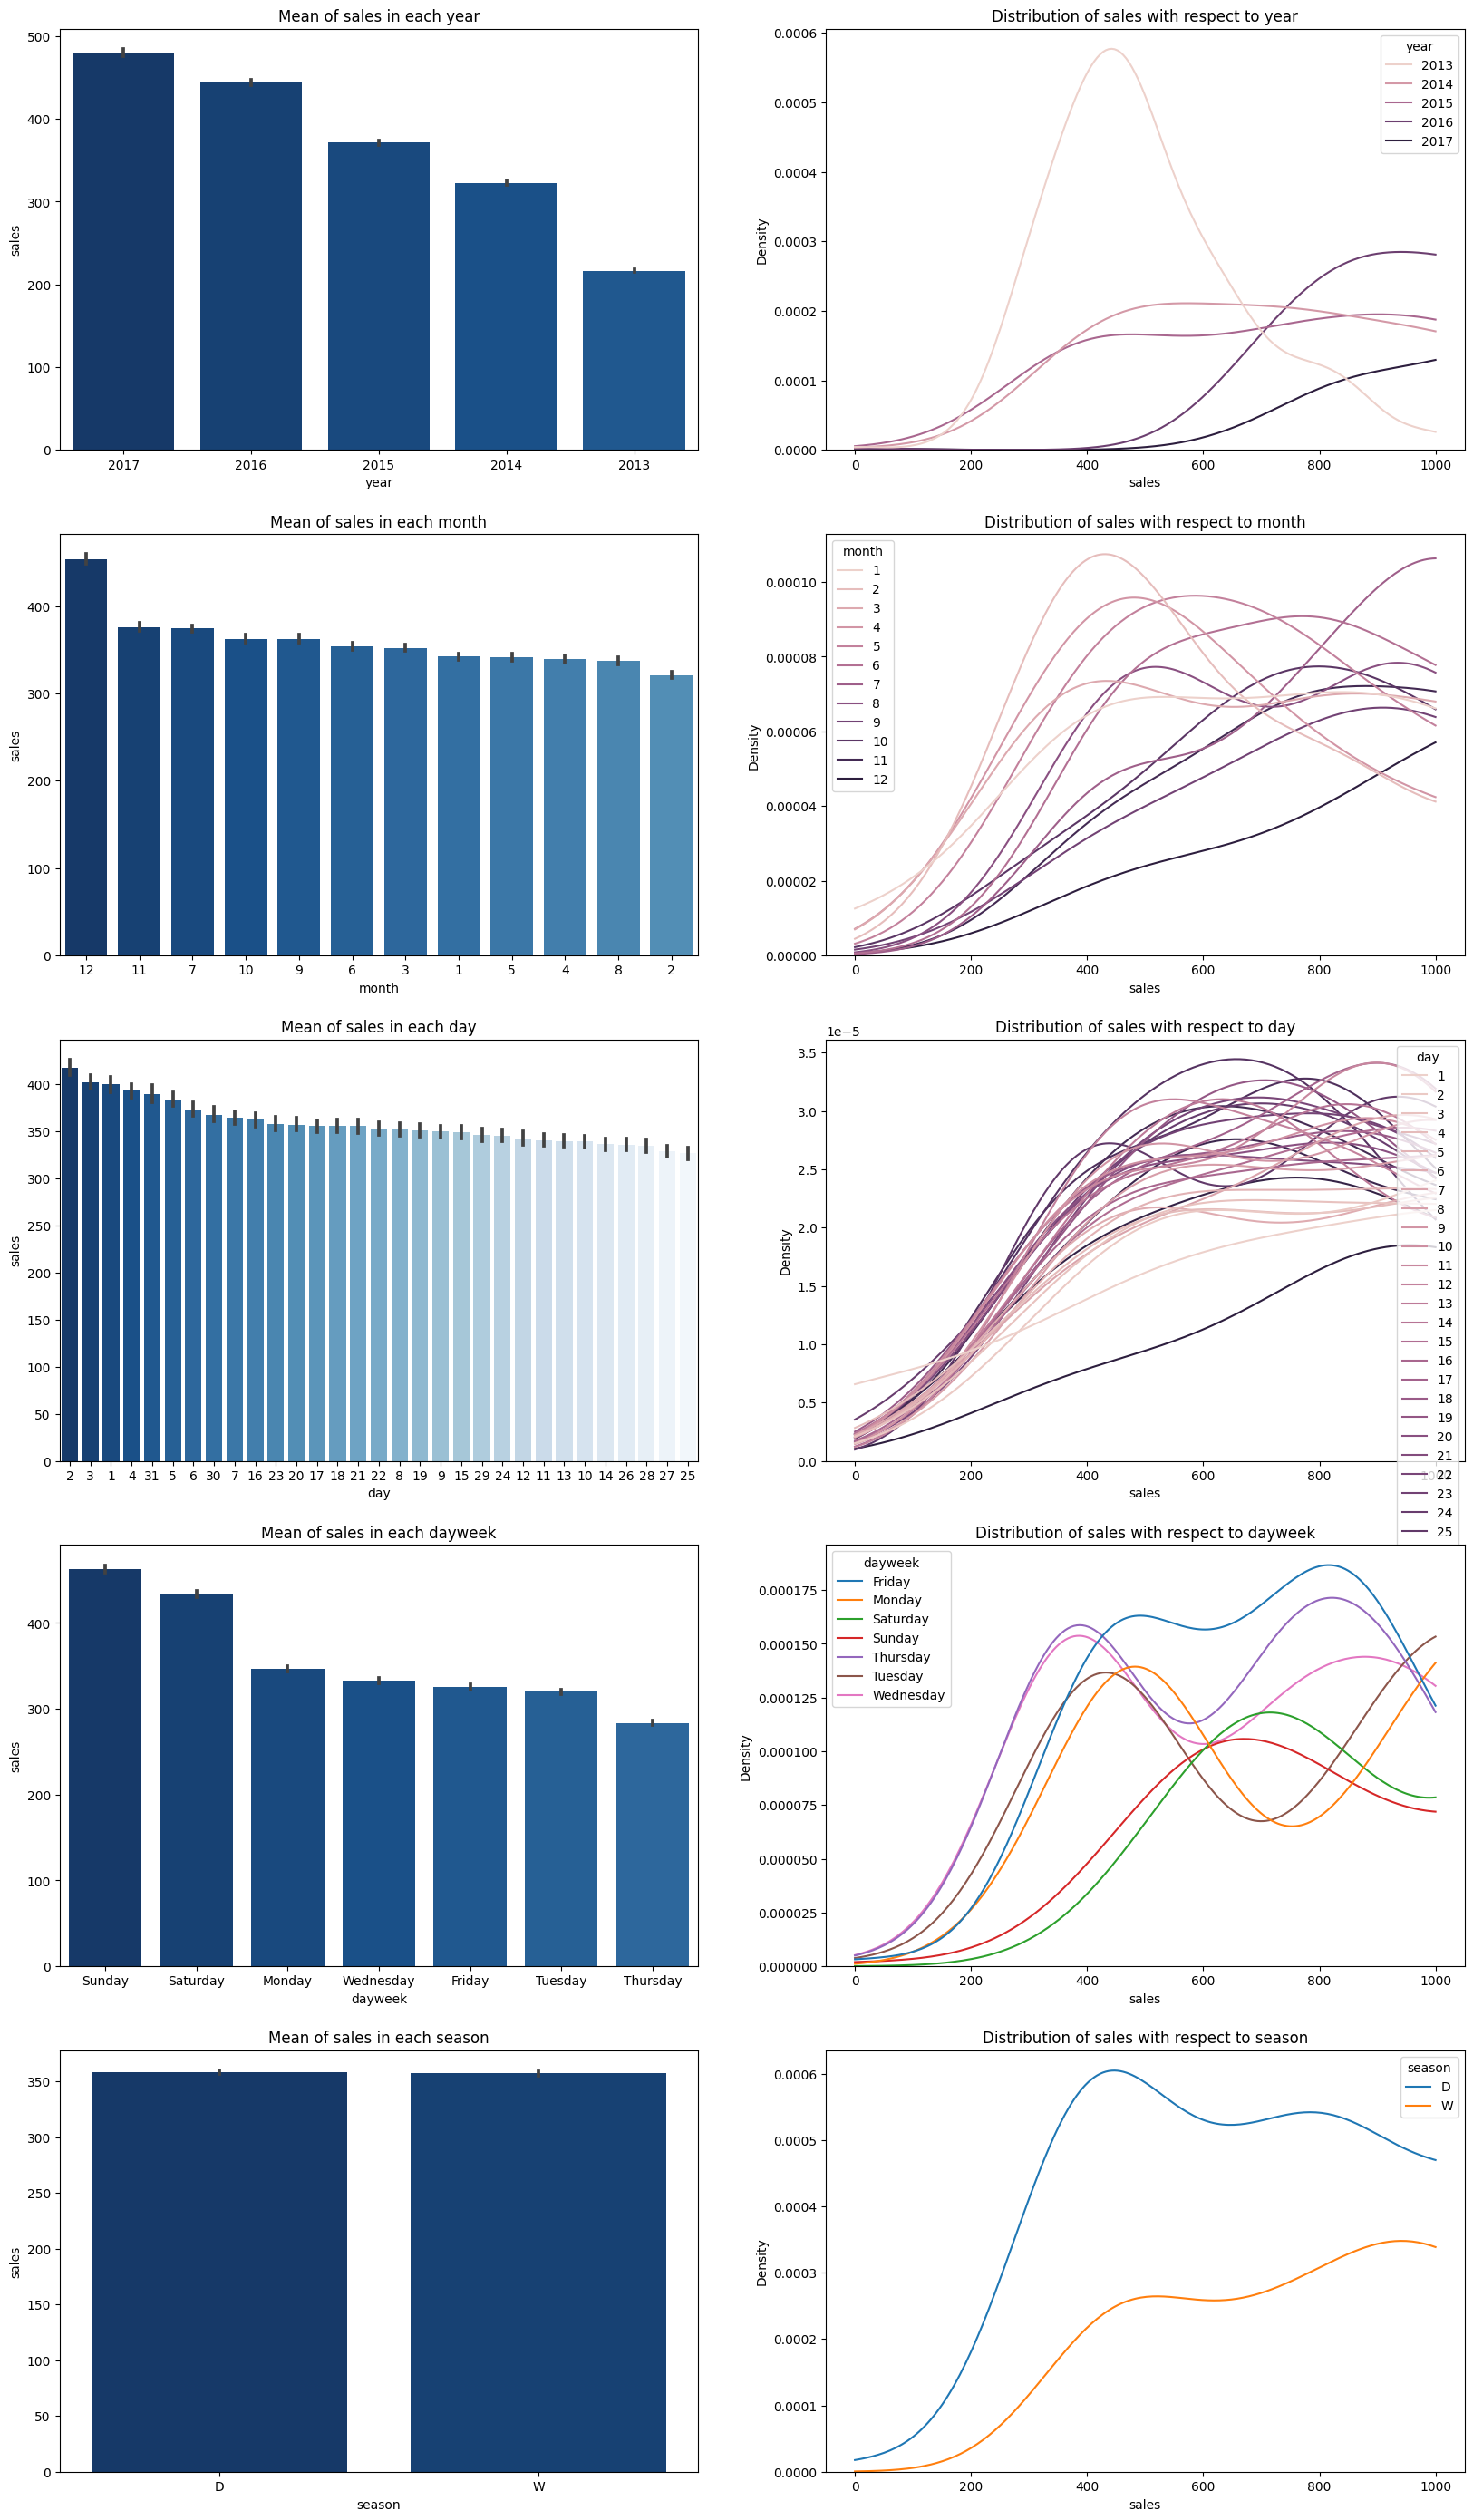

In [32]:
fig , ax = plt.subplots(5,2, figsize = (20, 35))
time_features = ["year", "month", "day", "dayweek", "season"]
colors = sns.color_palette("Blues", n_colors= 31)
colors = colors[::-1]

for ind, value in enumerate(time_features):
    sns.barplot(data = df, x = value, y = 'sales', ax = ax[ind, 0], order = df.groupby(value)['sales'].mean().sort_values(ascending= False).index, palette= colors)
    ax[ind, 0].set_title(f"Mean of sales in each {value}")

    sns.kdeplot(data =df1, x = 'sales', hue = value, ax = ax[ind, 1], clip = (0, 1000))
    ax[ind,1].set_title(f"Distribution of sales with respect to {value}")

In [22]:
b = df.groupby(["month", "year"]).sales.mean().reset_index()
px.line(b, x = "month", y = "sales", color = "year", title = "Mean of sales in each month per year")

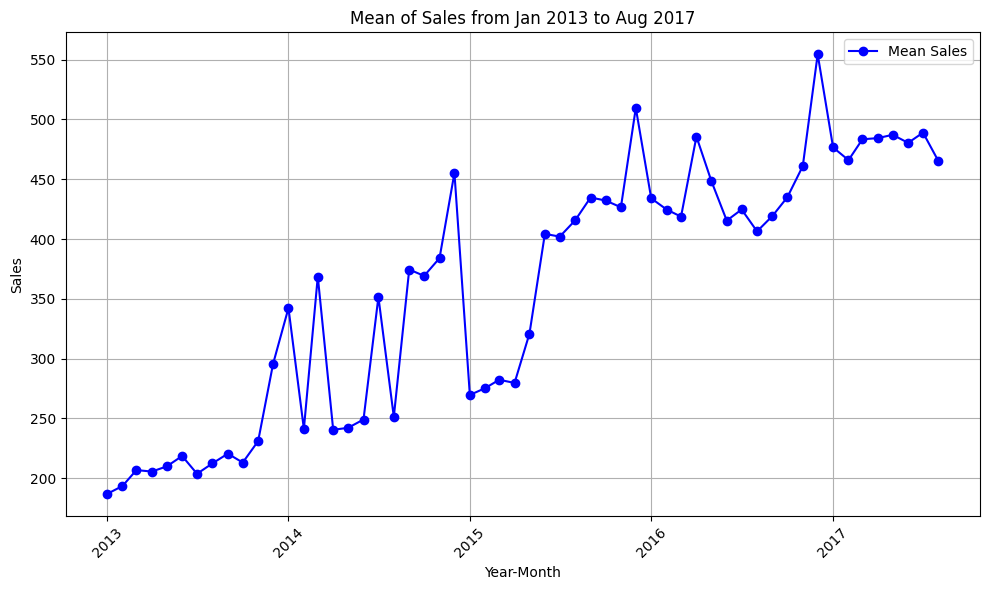

In [33]:
b1 = df1.groupby("yearmonth").sales.mean().reset_index()
fig = px.line(b1, x="yearmonth", y="sales", title="Mean of Sales from Jan 2013 to Aug 2017")
#fig.show()

# Assuming you have the 'b1' DataFrame with 'yearmonth' and 'sales' columns
plt.figure(figsize=(10, 6))
plt.plot(b1['yearmonth'], b1['sales'], marker='o', color='b', label='Mean Sales')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.title('Mean of Sales from Jan 2013 to Aug 2017')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


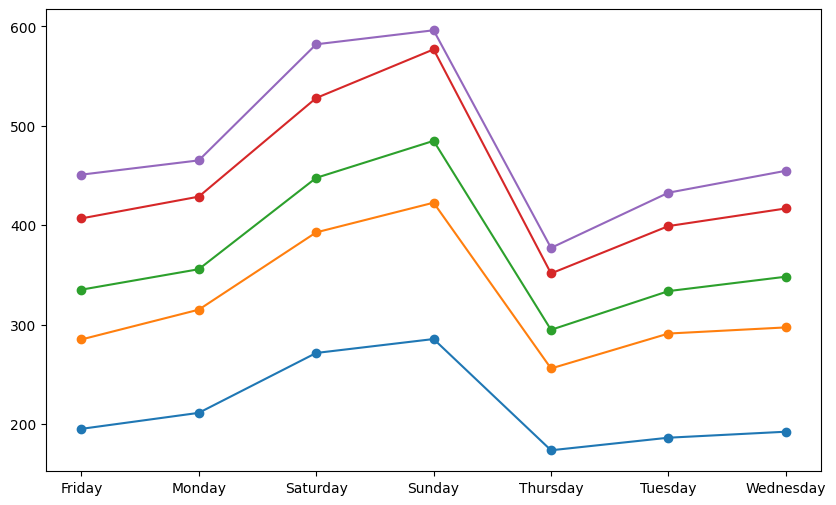

In [36]:
c = df.groupby(["dayweek", "year"]).sales.mean().reset_index()
#px.line(c, x = "dayweek", y = "sales", color = "year", title = "Mean of sales in each day of week per year")

plt.figure(figsize=(10, 6))

# Iterate over unique years and plot data for each year with different colors
for year in c['year'].unique():
    subset = c[c['year'] == year]
    plt.plot(subset['dayweek'], subset['sales'], marker='o', label=f'Year {year}')

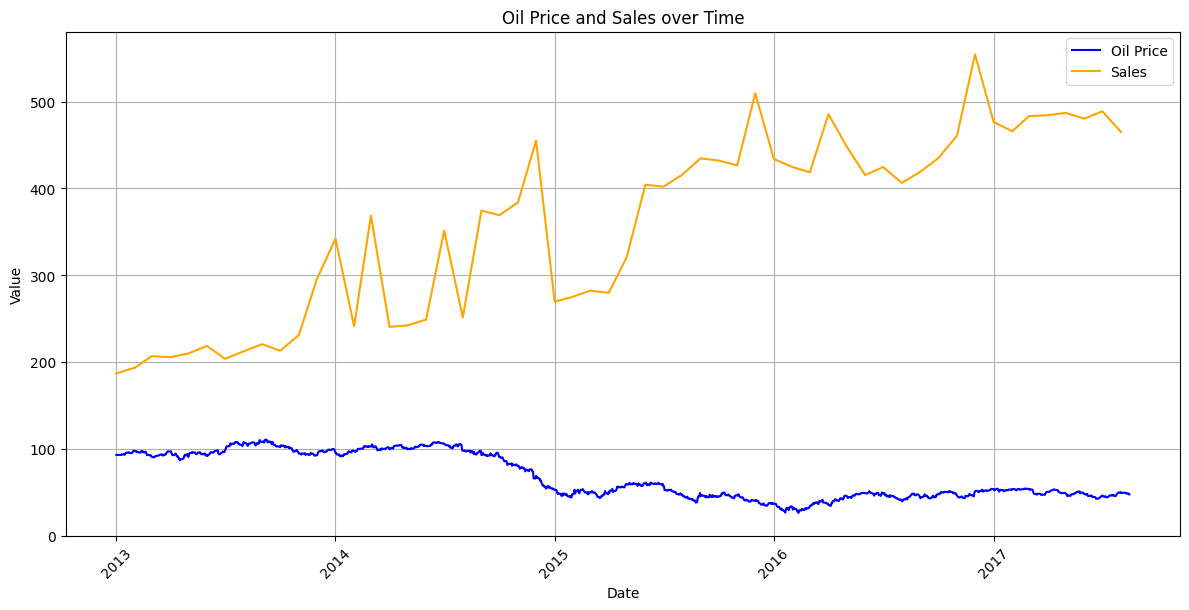

In [37]:
plt.figure(figsize=(12, 6))

# Plot Oil Price
plt.plot(df['date'], df['dcoilwtico'], color='blue', label='Oil Price')

# Plot Sales
plt.plot(b1['yearmonth'], b1['sales'], color='orange', label='Sales')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Oil Price and Sales over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# Seasonal decomposition

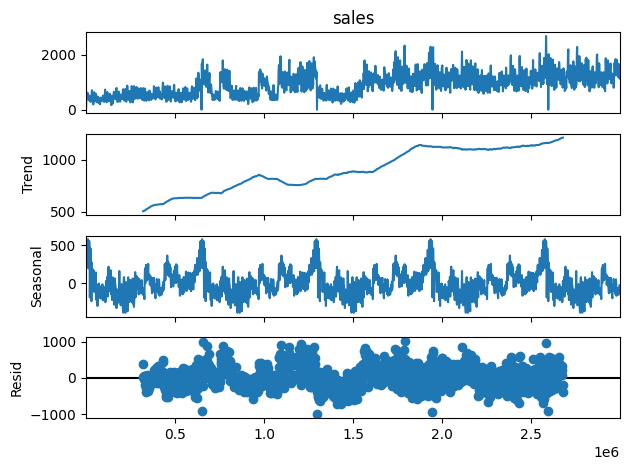

<Figure size 2000x3000 with 0 Axes>

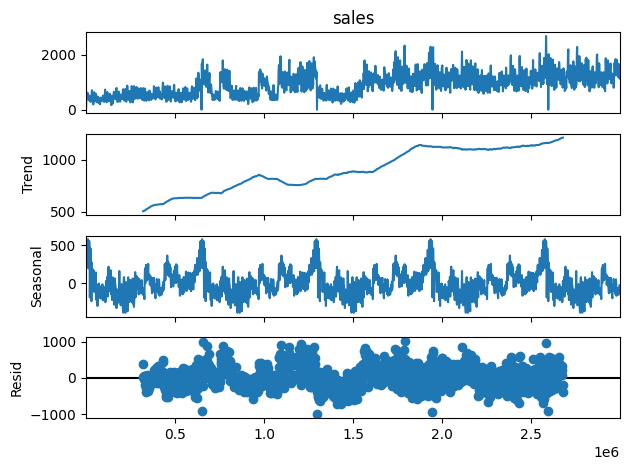

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

family = 'BEVERAGES'
store_nbr = 10
df1 = df[(df['store_nbr']==store_nbr) & (df['family']==family)]


plt.figure(figsize = (20,30))

analysis = df1['sales']

decompose_result_mult = seasonal_decompose(analysis, period =360)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

### ACF and periodicity
To determine the seasonality period from the decomposed time series, we can analyze the seasonal component to identify repeating patterns. One way to do this is by using autocorrelation function (ACF) plot. ACF measures the correlation between a time series and its lagged values. In the context of seasonality, we can use ACF to find the periodicity in the data.

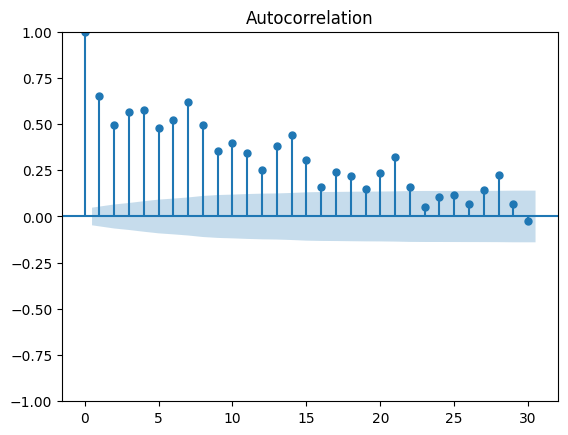

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

# Calculate ACF for seasonal component
acf_result = plot_acf(seasonal.dropna(), lags=30)

# Show the plot
plt.show()